# Import and Structure Data

In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import cv2
import albumentations as A

from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

/opt/anaconda3/lib/python3.12/site-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.5' (you have '2.0.4'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [2]:
# Define the path to the 'image' folder
main_folder = "images"  # Change this to your actual path

# List to store image paths and their corresponding breed names
data = []

# Iterate through each folder inside the "image" directory
for breed_name in os.listdir(main_folder):
    breed_path = os.path.join(main_folder, breed_name)
    
    # Ensure it's a directory
    if os.path.isdir(breed_path):
        # Iterate through each image in the breed's folder
        for image_name in os.listdir(breed_path):
            image_path = os.path.join(breed_path, image_name)
            data.append([image_path, breed_name])  # Append image path and breed name

# Create DataFrame
df = pd.DataFrame(data, columns=["image_path", "breed"])

# Save the DataFrame to a CSV file (optional)
df.to_csv("dog_breeds_dataset.csv", index=False)

In [3]:
df['breed'] = df['breed'].str.replace(r'n\d{8}-', '', regex=True)

In [4]:
df

,image_path,breed
0,images/n02097658-silky_terrier/n02097658_26.jpg,silky_terrier
1,images/n02097658-silky_terrier/n02097658_4869.jpg,silky_terrier
2,images/n02097658-silky_terrier/n02097658_595.jpg,silky_terrier
3,images/n02097658-silky_terrier/n02097658_9222.jpg,silky_terrier
4,images/n02097658-silky_terrier/n02097658_422.jpg,silky_terrier
...,...,...
20575,images/n02089078-black-and-tan_coonhound/n0208...,black-and-tan_coonhound
20576,images/n02089078-black-and-tan_coonhound/n0208...,black-and-tan_coonhound
20577,images/n02089078-black-and-tan_coonhound/n0208...,black-and-tan_coonhound
20578,images/n02089078-black-and-tan_coonhound/n0208...,black-and-tan_coonhound


# Image Preprocessing & Data split

In [6]:
def resize_with_padding(img_path, target_size=(224, 224)):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
    
    if img is None:
        print(f"Error loading image: {img_path}")
        return None
    
    h, w, _ = img.shape
    scale = min(target_size[0] / h, target_size[1] / w)  # Scale factor
    new_size = (int(w * scale), int(h * scale))

    img_resized = cv2.resize(img, new_size, interpolation=cv2.INTER_AREA)

    # Create a blank canvas (black background)
    canvas = np.zeros((target_size[0], target_size[1], 3), dtype=np.uint8)

    # Compute offsets for centering
    x_offset = (target_size[1] - new_size[0]) // 2
    y_offset = (target_size[0] - new_size[1]) // 2
    canvas[y_offset:y_offset + new_size[1], x_offset:x_offset + new_size[0]] = img_resized

    return canvas / 255.0  # Normalize pixel values (0 to 1)

In [7]:
# Encode breed labels as integers
breed_names = df["breed"].unique()
breed_to_index = {breed: i for i, breed in enumerate(breed_names)}
df["breed_index"] = df["breed"].map(breed_to_index)

# Split into train (80%), validation (10%), test (10%)
train_df, temp_df = train_test_split(df, test_size=0.2, stratify=df["breed_index"], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df["breed_index"], random_state=42)

print(f"Training Samples: {len(train_df)}, Validation Samples: {len(val_df)}, Test Samples: {len(test_df)}")

# Convert image paths to arrays with resizing
X_train = np.array([resize_with_padding(img) for img in train_df["image_path"]])
X_val = np.array([resize_with_padding(img) for img in val_df["image_path"]])
X_test = np.array([resize_with_padding(img) for img in test_df["image_path"]])

# Convert labels to categorical (one-hot encoding)
y_train = to_categorical(train_df["breed_index"], num_classes=len(breed_names))
y_val = to_categorical(val_df["breed_index"], num_classes=len(breed_names))
y_test = to_categorical(test_df["breed_index"], num_classes=len(breed_names))

Training Samples: 16464, Validation Samples: 2058, Test Samples: 2058


In [81]:
df

,image_path,breed,breed_index
0,images/n02097658-silky_terrier/n02097658_26.jpg,silky_terrier,0
1,images/n02097658-silky_terrier/n02097658_4869.jpg,silky_terrier,0
2,images/n02097658-silky_terrier/n02097658_595.jpg,silky_terrier,0
3,images/n02097658-silky_terrier/n02097658_9222.jpg,silky_terrier,0
4,images/n02097658-silky_terrier/n02097658_422.jpg,silky_terrier,0
...,...,...,...
20575,images/n02089078-black-and-tan_coonhound/n0208...,black-and-tan_coonhound,119
20576,images/n02089078-black-and-tan_coonhound/n0208...,black-and-tan_coonhound,119
20577,images/n02089078-black-and-tan_coonhound/n0208...,black-and-tan_coonhound,119
20578,images/n02089078-black-and-tan_coonhound/n0208...,black-and-tan_coonhound,119


# Models

## MobileNet Basic

In [16]:
from tensorflow.keras.applications import MobileNet
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Augmentation for training set
train_datagen = ImageDataGenerator(
    rescale=1.0/255,            # Normalize images
    rotation_range=30,          # Random rotation
    width_shift_range=0.2,      # Random width shift
    height_shift_range=0.2,     # Random height shift
    shear_range=0.2,            # Shearing
    zoom_range=0.2,             # Random zoom
    horizontal_flip=True,       # Flip images horizontally
    fill_mode='nearest'         # Fill missing pixels after transformation
)

# Validation and test data should not be augmented (only rescaled)
val_test_datagen = ImageDataGenerator(rescale=1.0/255)

# Creating data generators
train_generator = train_datagen.flow_from_dataframe(
    train_df, directory=None, x_col="image_path", y_col="breed",
    target_size=(224, 224), batch_size=32, class_mode="categorical", shuffle=True
)

val_generator = val_test_datagen.flow_from_dataframe(
    val_df, directory=None, x_col="image_path", y_col="breed",
    target_size=(224, 224), batch_size=32, class_mode="categorical", shuffle=False
)

test_generator = val_test_datagen.flow_from_dataframe(
    test_df, directory=None, x_col="image_path", y_col="breed",
    target_size=(224, 224), batch_size=32, class_mode="categorical", shuffle=False
)

# Load MobileNet without top layers
base_model = MobileNet(include_top=False, input_shape=(224, 224, 3), weights="imagenet")
base_model.trainable = False  # Freeze the base model

# Add custom classifier head
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(512, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(120, activation='softmax')  # 120 dog breeds
])

# Compile the model
model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

# Define callbacks
early_stopping = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

model_checkpoint = ModelCheckpoint(
    "dog_breed_model.keras", monitor="val_loss", save_best_only=True
)

reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, min_lr=1e-6, verbose=1)

# Train the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30,
    callbacks=[early_stopping, model_checkpoint, reduce_lr]
)

model.save("final_dog_breed_model_MobileNet_Basic.keras")
print("✅ Model saved as 'final_dog_breed_model_MobileNet_Basic.keras'")

# Evaluate the model on the test set and print the accuracy
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc:.4f}")

2025-03-03 09:32:40.227029: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2025-03-03 09:32:40.227424: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-03-03 09:32:40.227434: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-03-03 09:32:40.227623: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-03-03 09:32:40.227820: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
/opt/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in it

Epoch 1/30


2025-03-03 09:32:43.196724: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
2025-03-03 09:32:43.201568: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step - accuracy: 0.0521 - loss: 5.1092  

2025-03-03 09:35:52.157273: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


515/515 ━━━━━━━━━━━━━━━━━━━━ 206s 393ms/step - accuracy: 0.0522 - loss: 5.1077 - val_accuracy: 0.4140 - val_loss: 2.3534 - learning_rate: 1.0000e-04
Epoch 2/30
515/515 ━━━━━━━━━━━━━━━━━━━━ 193s 374ms/step - accuracy: 0.2896 - loss: 2.9156 - val_accuracy: 0.5914 - val_loss: 1.5524 - learning_rate: 1.0000e-04
Epoch 3/30
515/515 ━━━━━━━━━━━━━━━━━━━━ 195s 379ms/step - accuracy: 0.4255 - loss: 2.1914 - val_accuracy: 0.6657 - val_loss: 1.2278 - learning_rate: 1.0000e-04
Epoch 4/30
515/515 ━━━━━━━━━━━━━━━━━━━━ 204s 397ms/step - accuracy: 0.4994 - loss: 1.8265 - val_accuracy: 0.7065 - val_loss: 1.0483 - learning_rate: 1.0000e-04
Epoch 5/30
515/515 ━━━━━━━━━━━━━━━━━━━━ 194s 377ms/step - accuracy: 0.5487 - loss: 1.6374 - val_accuracy: 0.7269 - val_loss: 0.9428 - learning_rate: 1.0000e-04
Epoch 6/30
515/515 ━━━━━━━━━━━━━━━━━━━━ 194s 376ms/step - accuracy: 0.5872 - loss: 1.4574 - val_accuracy: 0.7430 - val_loss: 0.8722 - learning_rate: 1.0000e-04
Epoch 7/30
515/515 ━━━━━━━━━━━━━━━━━━━━ 196s 380ms/

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenet_1.00_224 (Functional) │ (None, 7, 7, 1024)     │     3,228,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 120)            │        61,560 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,992,042 (19.04 MB)

 Trainable params: 587,384 (2.24 MB)

 Non-trainable params: 3,229,888 (12.32 MB)

 Optimizer params: 1,174,770 (4.48 MB)

### Evaluation 

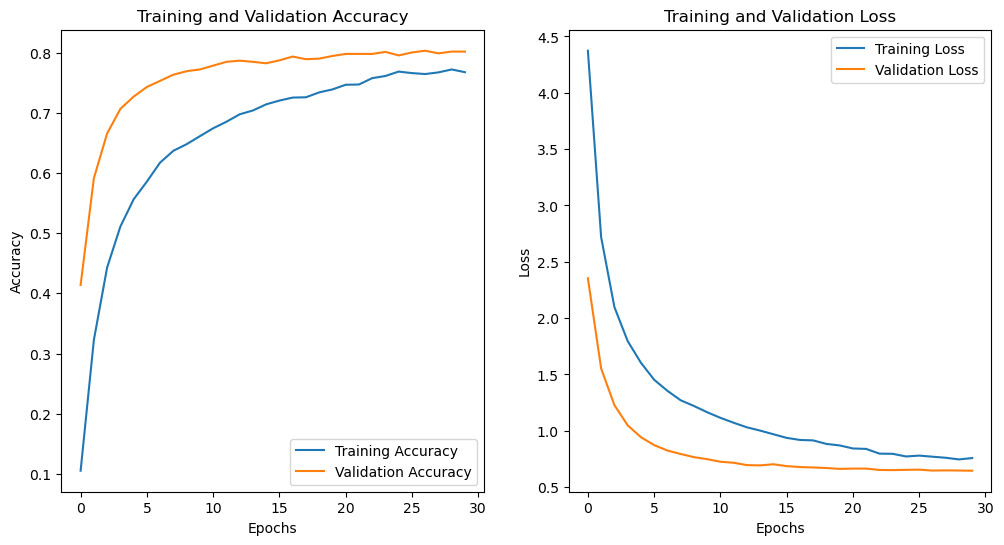

In [24]:
import matplotlib.pyplot as plt

# Function to plot training history
def plot_history(history):
    # Accuracy plot
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

# Assuming you have the history object from model.fit()
plot_history(history)

## MobileNet Advanced

In [45]:
from tensorflow.keras.applications import MobileNet
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Augmentation for training set
train_datagen = ImageDataGenerator(
    rescale=1.0/255,            # Normalize images
    rotation_range=30,          # Random rotation
    width_shift_range=0.2,      # Random width shift
    height_shift_range=0.2,     # Random height shift
    shear_range=0.2,            # Shearing
    zoom_range=0.2,             # Random zoom
    horizontal_flip=True,       # Flip images horizontally
    fill_mode='nearest'         # Fill missing pixels after transformation
)

# Validation and test data should not be augmented (only rescaled)
val_test_datagen = ImageDataGenerator(rescale=1.0/255)

# Creating data generators
train_generator = train_datagen.flow_from_dataframe(
    train_df, directory=None, x_col="image_path", y_col="breed",
    target_size=(224, 224), batch_size=32, class_mode="categorical", shuffle=True
)

val_generator = val_test_datagen.flow_from_dataframe(
    val_df, directory=None, x_col="image_path", y_col="breed",
    target_size=(224, 224), batch_size=32, class_mode="categorical", shuffle=False
)

test_generator = val_test_datagen.flow_from_dataframe(
    test_df, directory=None, x_col="image_path", y_col="breed",
    target_size=(224, 224), batch_size=32, class_mode="categorical", shuffle=False
)

# Load MobileNet without top layers
base_model = MobileNet(include_top=False, input_shape=(224, 224, 3), weights="imagenet")
base_model.trainable = True  # Initially unfreeze the entire base model

# Unfreeze the last 20 layers of the base model
for layer in base_model.layers[-20:]:
    layer.trainable = True  # Unfreeze the last 20 layers

# Freeze the first layers (keep them frozen)
for layer in base_model.layers[:-20]:
    layer.trainable = False  # Freeze the first layers

# Add custom classifier head
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(512, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(120, activation='softmax')  # 120 dog breeds
])

# Compile the model
model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

# Compute class weights to handle class imbalance
class_weights = compute_class_weight(
    'balanced', 
    classes=np.unique(train_generator.classes), 
    y=train_generator.classes
)
class_weight_dict = dict(enumerate(class_weights))

# Define callbacks
early_stopping = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

model_checkpoint = ModelCheckpoint(
    "dog_breed_model.keras", monitor="val_loss", save_best_only=True
)

reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5, min_lr=1e-6, verbose=1)

# Train the model with 50 epochs
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,  # Updated to 50 epochs
    class_weight=class_weight_dict,  # Pass the class weights
    callbacks=[early_stopping, model_checkpoint, reduce_lr]
)

# Save the model at the end of training
model.save("dog_breed_model_final_MobileNet_advanced.keras")  # Save the final model

# Evaluate the model on the test set and print the accuracy
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc:.4f}")

Found 16464 validated image filenames belonging to 120 classes.
Found 2058 validated image filenames belonging to 120 classes.
Found 2058 validated image filenames belonging to 120 classes.


/opt/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50


2025-03-03 12:01:01.988771: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step - accuracy: 0.0766 - loss: 4.8299  

2025-03-03 12:04:57.228342: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


515/515 ━━━━━━━━━━━━━━━━━━━━ 254s 476ms/step - accuracy: 0.0767 - loss: 4.8281 - val_accuracy: 0.5238 - val_loss: 1.8523 - learning_rate: 1.0000e-04
Epoch 2/50
515/515 ━━━━━━━━━━━━━━━━━━━━ 242s 469ms/step - accuracy: 0.3835 - loss: 2.3702 - val_accuracy: 0.6443 - val_loss: 1.2775 - learning_rate: 1.0000e-04
Epoch 3/50
515/515 ━━━━━━━━━━━━━━━━━━━━ 240s 466ms/step - accuracy: 0.5130 - loss: 1.7993 - val_accuracy: 0.6934 - val_loss: 1.0958 - learning_rate: 1.0000e-04
Epoch 4/50
515/515 ━━━━━━━━━━━━━━━━━━━━ 263s 510ms/step - accuracy: 0.5806 - loss: 1.5078 - val_accuracy: 0.7250 - val_loss: 0.9579 - learning_rate: 1.0000e-04
Epoch 5/50
515/515 ━━━━━━━━━━━━━━━━━━━━ 250s 485ms/step - accuracy: 0.6199 - loss: 1.3537 - val_accuracy: 0.7221 - val_loss: 0.9193 - learning_rate: 1.0000e-04
Epoch 6/50
515/515 ━━━━━━━━━━━━━━━━━━━━ 231s 449ms/step - accuracy: 0.6533 - loss: 1.2055 - val_accuracy: 0.7235 - val_loss: 0.9035 - learning_rate: 1.0000e-04
Epoch 7/50
515/515 ━━━━━━━━━━━━━━━━━━━━ 238s 462ms/

### Evaluation

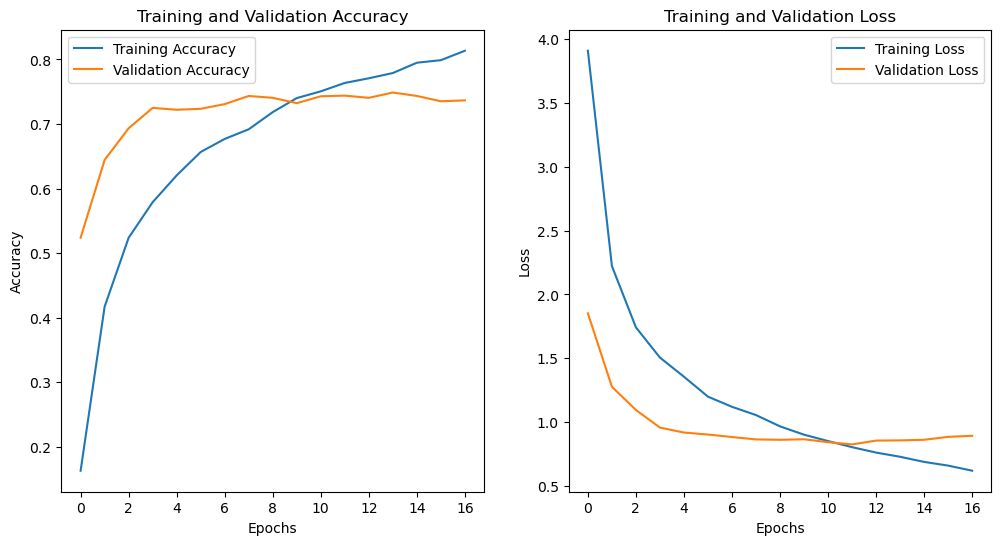

In [47]:
import matplotlib.pyplot as plt

# Function to plot training history
def plot_history(history):
    # Accuracy plot
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

# Assuming you have the history object from model.fit()
plot_history(history)

In [ ]:
import seaborn as sns
import numpy as np
import tensorflow as tf
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# Get predictions from the model
y_pred = model.predict(test_generator, batch_size=32)
y_pred_classes = np.argmax(y_pred, axis=1)

# Get true labels
y_true = []
for _, labels in test_generator:
    y_true.extend(labels)  # Collect the true labels for each batch

y_true = np.array(y_true)

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Plot confusion matrix using seaborn heatmap
def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

# Class names
class_names = list(test_generator.class_indices.keys())

# Plot the confusion matrix
plot_confusion_matrix(cm, class_names)

## MobileNet Hyperparameters

In [13]:
from tensorflow.keras.applications import MobileNet
from tensorflow.keras import layers, models, optimizers, regularizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Augmentation for training set
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=40,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Validation and test data should only be rescaled
val_test_datagen = ImageDataGenerator(rescale=1.0/255)

# Creating data generators
train_generator = train_datagen.flow_from_dataframe(
    train_df, x_col="image_path", y_col="breed",
    target_size=(224, 224), batch_size=32, class_mode="categorical", shuffle=True
)

val_generator = val_test_datagen.flow_from_dataframe(
    val_df, x_col="image_path", y_col="breed",
    target_size=(224, 224), batch_size=32, class_mode="categorical", shuffle=False
)

test_generator = val_test_datagen.flow_from_dataframe(
    test_df, x_col="image_path", y_col="breed",
    target_size=(224, 224), batch_size=32, class_mode="categorical", shuffle=False
)

# Load MobileNet with pre-trained weights
base_model = MobileNet(include_top=False, input_shape=(224, 224, 3), weights="imagenet")

# ❗ Unfreeze last 5 layers for fine-tuning
for layer in base_model.layers[-5:]:
    layer.trainable = True

# Add custom classifier head
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.01)),  # L2 Regularization
    layers.BatchNormalization(),
    layers.Dropout(0.4),  # Reduce dropout to prevent underfitting
    layers.Dense(120, activation='softmax')  # 120 dog breeds
])

# Compile with lower LR for fine-tuning
model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-5),  # Lower LR for stable fine-tuning
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

# Define callbacks
early_stopping = EarlyStopping(monitor="val_loss", patience=6, restore_best_weights=True)

model_checkpoint = ModelCheckpoint(
    "dog_breed_finetuned.keras", monitor="val_loss", save_best_only=True
)

reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-7, verbose=1)

# Fine-tune model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,  # More epochs to allow fine-tuning
    callbacks=[early_stopping, model_checkpoint, reduce_lr]
)

# Save fine-tuned model
model.save("final_dog_breed_model_MobileNet_Finetuned.keras")
print("✅ Fine-tuned model saved as 'final_dog_breed_model_MobileNet_Finetuned.keras'")

# Evaluate on test set
test_loss, test_acc = model.evaluate(test_generator)
print(f"🎯 Fine-tuned Test Accuracy: {test_acc:.4f}")

Found 16464 validated image filenames belonging to 120 classes.
Found 2058 validated image filenames belonging to 120 classes.
Found 2058 validated image filenames belonging to 120 classes.


2025-03-03 15:43:27.352479: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2025-03-03 15:43:27.352705: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-03-03 15:43:27.352711: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-03-03 15:43:27.352734: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-03-03 15:43:27.352749: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
/opt/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in it

Epoch 1/50


2025-03-03 15:43:32.940572: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
2025-03-03 15:43:32.970208: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.0106 - loss: 12.6160  

2025-03-03 15:53:45.819915: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


515/515 ━━━━━━━━━━━━━━━━━━━━ 634s 1s/step - accuracy: 0.0107 - loss: 12.6157 - val_accuracy: 0.0423 - val_loss: 11.4442 - learning_rate: 1.0000e-05
Epoch 2/50
515/515 ━━━━━━━━━━━━━━━━━━━━ 603s 1s/step - accuracy: 0.0313 - loss: 11.8157 - val_accuracy: 0.1088 - val_loss: 10.6746 - learning_rate: 1.0000e-05
Epoch 3/50
515/515 ━━━━━━━━━━━━━━━━━━━━ 615s 1s/step - accuracy: 0.0715 - loss: 11.1491 - val_accuracy: 0.2055 - val_loss: 9.9681 - learning_rate: 1.0000e-05
Epoch 4/50
515/515 ━━━━━━━━━━━━━━━━━━━━ 599s 1s/step - accuracy: 0.1323 - loss: 10.5188 - val_accuracy: 0.2925 - val_loss: 9.3654 - learning_rate: 1.0000e-05
Epoch 5/50
515/515 ━━━━━━━━━━━━━━━━━━━━ 543s 1s/step - accuracy: 0.1808 - loss: 10.0038 - val_accuracy: 0.3814 - val_loss: 8.8895 - learning_rate: 1.0000e-05
Epoch 6/50
515/515 ━━━━━━━━━━━━━━━━━━━━ 361s 700ms/step - accuracy: 0.2316 - loss: 9.5932 - val_accuracy: 0.4485 - val_loss: 8.4995 - learning_rate: 1.0000e-05
Epoch 7/50
515/515 ━━━━━━━━━━━━━━━━━━━━ 526s 1s/step - accu

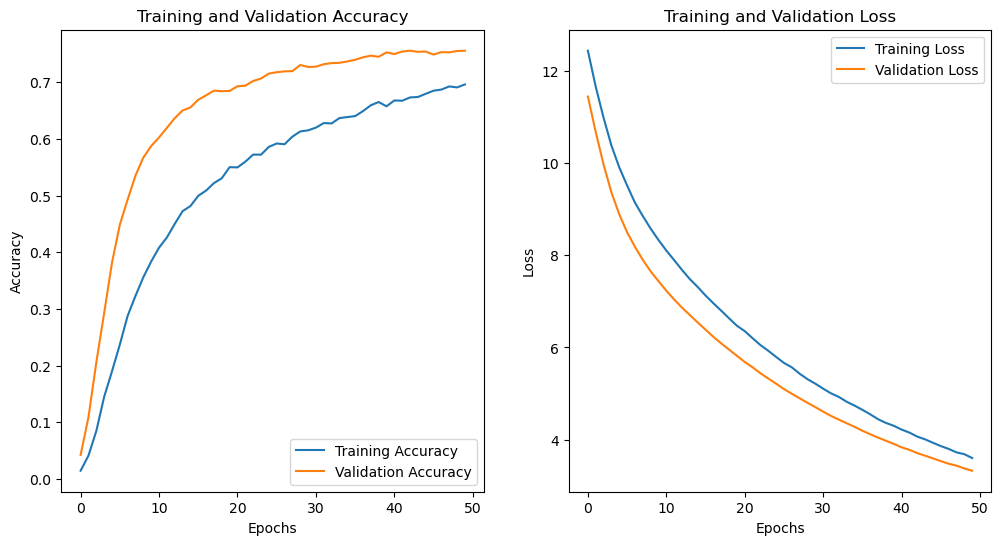

In [18]:
import matplotlib.pyplot as plt

# Function to plot training history
def plot_history(history):
    # Accuracy plot
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

# Assuming you have the history object from model.fit()
plot_history(history)

## MobileNet ClassWeights

In [ ]:
from tensorflow.keras.applications import MobileNet
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Augmentation for training set
train_datagen = ImageDataGenerator(
    rescale=1.0/255,            
    rotation_range=30,          
    width_shift_range=0.2,      
    height_shift_range=0.2,     
    shear_range=0.2,            
    zoom_range=0.2,             
    horizontal_flip=True,       
    fill_mode='nearest'         
)

# Validation & test sets should not be augmented
val_test_datagen = ImageDataGenerator(rescale=1.0/255)

# Creating data generators
train_generator = train_datagen.flow_from_dataframe(
    train_df, directory=None, x_col="image_path", y_col="breed",
    target_size=(224, 224), batch_size=32, class_mode="categorical", shuffle=True
)

val_generator = val_test_datagen.flow_from_dataframe(
    val_df, directory=None, x_col="image_path", y_col="breed",
    target_size=(224, 224), batch_size=32, class_mode="categorical", shuffle=False
)

test_generator = val_test_datagen.flow_from_dataframe(
    test_df, directory=None, x_col="image_path", y_col="breed",
    target_size=(224, 224), batch_size=32, class_mode="categorical", shuffle=False
)

# Compute class weights
class_labels = train_generator.classes  # Get class indices
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(class_labels),
    y=class_labels
)

class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}
print("🔹 Computed class weights:", class_weight_dict)

# Load MobileNet without top layers
base_model = MobileNet(include_top=False, input_shape=(224, 224, 3), weights="imagenet")
base_model.trainable = False  # Freeze the base model

# Define Learning Rate Scheduler
lr_schedule = ExponentialDecay(
    initial_learning_rate=1e-4, decay_steps=1000, decay_rate=0.9, staircase=True
)

# Define the model with a deeper classifier head
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(1024, activation='relu'),  # Increased neurons
    layers.BatchNormalization(),
    layers.Dropout(0.4),
    layers.Dense(512, activation='relu'),   # Additional dense layer
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(120, activation='softmax') 
])

# Compile the model with a learning rate scheduler
optimizer = optimizer=optimizers.Adam(learning_rate=1e-4)
model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

# Define callbacks
early_stopping = EarlyStopping(monitor="val_loss", patience=8, restore_best_weights=True)

model_checkpoint = ModelCheckpoint(
    "final_dog_breed_model_MobileNet_Balanced.keras", monitor="val_loss", save_best_only=True
)

reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, min_lr=1e-6, verbose=1)

# Train the model with class weights
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,
    class_weight=class_weight_dict,  # Apply class weights here
    callbacks=[early_stopping, model_checkpoint, reduce_lr]
)

model.save("final_dog_breed_model_MobileNet_Balanced.keras")
print("✅ Model saved as 'final_dog_breed_model_MobileNet_Balanced.keras'")

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc:.4f}")

### Evaluation

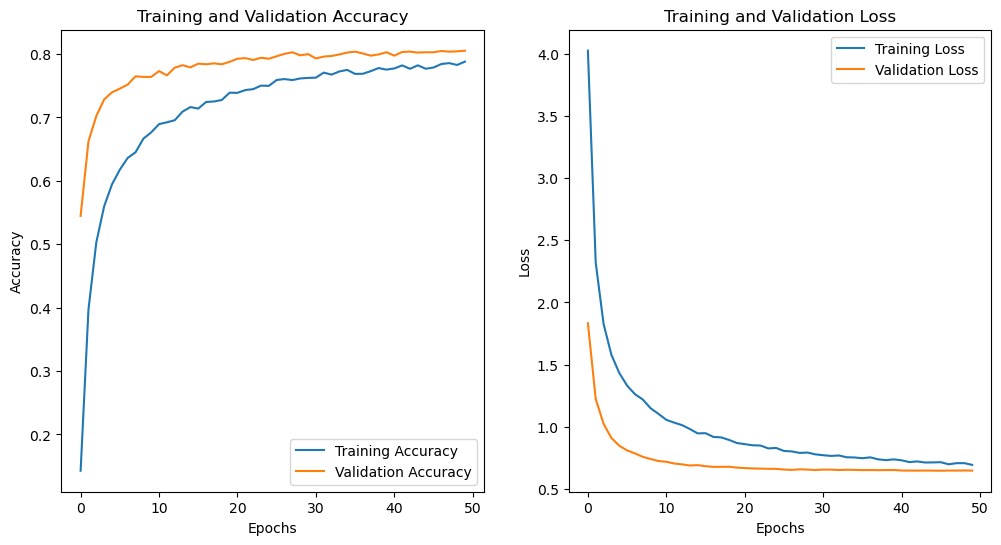

In [34]:
import matplotlib.pyplot as plt

# Function to plot training history
def plot_history(history):
    # Accuracy plot
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

# Assuming you have the history object from model.fit()
plot_history(history)

In [38]:
from tensorflow.keras.models import load_model
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Load the saved model
model = load_model("Models/final_dog_breed_model_MobileNet_Balanced.keras")
print("✅ Model loaded successfully!")

✅ Model loaded successfully!


In [40]:
# Get true labels and predicted labels
y_true = test_generator.classes  # True class labels
y_pred_probs = model.predict(test_generator)  # Probabilities from softmax layer
y_pred = np.argmax(y_pred_probs, axis=1)  # Convert probabilities to class indices

2025-03-04 14:25:48.242623: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


65/65 ━━━━━━━━━━━━━━━━━━━━ 18s 242ms/step


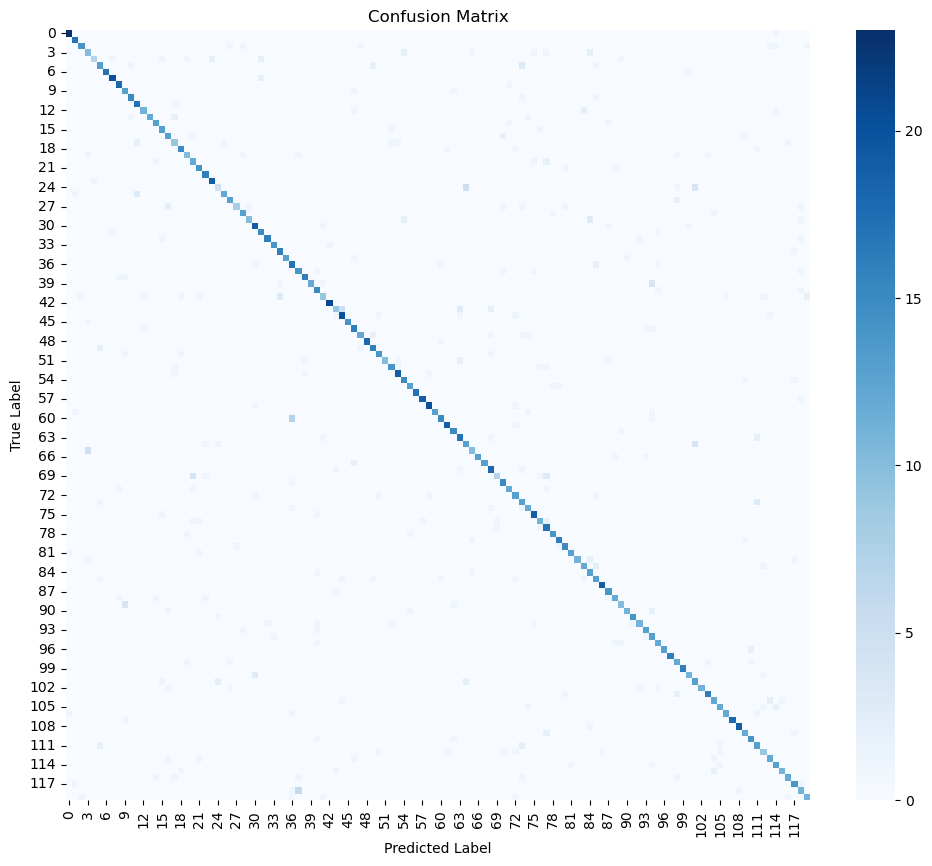

In [42]:
# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix, annot=False, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [89]:
from sklearn.metrics import classification_report
import pandas as pd
import numpy as np

# Get true labels from test_generator
y_true = test_generator.classes  # True labels from test dataset

# Predict probabilities
y_pred_prob = model.predict(test_generator)
y_pred = np.argmax(y_pred_prob, axis=1)  # Convert probabilities to class indices

# Get class labels
class_labels = list(test_generator.class_indices.keys())

# Generate classification report
report = classification_report(y_true, y_pred, target_names=class_labels, output_dict=True)

# Convert report to DataFrame for better visualization
report_df = pd.DataFrame(report).transpose()

2025-03-05 12:11:55.646589: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


65/65 ━━━━━━━━━━━━━━━━━━━━ 21s 271ms/step


## ResNet50 Basic

In [51]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Augmentation for training set
train_datagen = ImageDataGenerator(
    rescale=1.0/255,            # Normalize images
    rotation_range=30,          # Random rotation
    width_shift_range=0.2,      # Random width shift
    height_shift_range=0.2,     # Random height shift
    shear_range=0.2,            # Shearing
    zoom_range=0.2,             # Random zoom
    horizontal_flip=True,       # Flip images horizontally
    fill_mode='nearest'         # Fill missing pixels after transformation
)

# Validation and test data should only be rescaled (no augmentation)
val_test_datagen = ImageDataGenerator(rescale=1.0/255)

# Creating data generators
train_generator = train_datagen.flow_from_dataframe(
    train_df, directory=None, x_col="image_path", y_col="breed",
    target_size=(224, 224), batch_size=32, class_mode="categorical", shuffle=True
)

val_generator = val_test_datagen.flow_from_dataframe(
    val_df, directory=None, x_col="image_path", y_col="breed",
    target_size=(224, 224), batch_size=32, class_mode="categorical", shuffle=False
)

test_generator = val_test_datagen.flow_from_dataframe(
    test_df, directory=None, x_col="image_path", y_col="breed",
    target_size=(224, 224), batch_size=32, class_mode="categorical", shuffle=False
)

# Load ResNet50 without top layers
base_model = ResNet50(include_top=False, input_shape=(224, 224, 3), weights="imagenet")
base_model.trainable = False  # Freeze the base model

# Add custom classifier head
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(512, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(120, activation='softmax')  # 120 dog breeds
])

# Compile the model
model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

# Define callbacks
early_stopping = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

model_checkpoint = ModelCheckpoint(
    "dog_breed_model_ResNet50.keras", monitor="val_loss", save_best_only=True
)

reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, min_lr=1e-6, verbose=1)

# Train the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30,
    callbacks=[early_stopping, model_checkpoint, reduce_lr]
)

# Save the final model
model.save("final_dog_breed_model_ResNet50.keras")
print("✅ Model saved as 'final_dog_breed_model_ResNet50.keras'")

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc:.4f}")

Found 16464 validated image filenames belonging to 120 classes.
Found 2058 validated image filenames belonging to 120 classes.
Found 2058 validated image filenames belonging to 120 classes.


/opt/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30


2025-03-03 14:15:20.184657: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 790ms/step - accuracy: 0.0122 - loss: 5.0883  

2025-03-03 14:22:17.633196: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


515/515 ━━━━━━━━━━━━━━━━━━━━ 471s 894ms/step - accuracy: 0.0122 - loss: 5.0882 - val_accuracy: 0.0136 - val_loss: 4.8304 - learning_rate: 1.0000e-04
Epoch 2/30
515/515 ━━━━━━━━━━━━━━━━━━━━ 448s 870ms/step - accuracy: 0.0178 - loss: 4.8864 - val_accuracy: 0.0194 - val_loss: 5.0993 - learning_rate: 1.0000e-04
Epoch 3/30
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 781ms/step - accuracy: 0.0250 - loss: 4.8092  
Epoch 3: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
515/515 ━━━━━━━━━━━━━━━━━━━━ 443s 861ms/step - accuracy: 0.0250 - loss: 4.8092 - val_accuracy: 0.0224 - val_loss: 5.0064 - learning_rate: 1.0000e-04
Epoch 4/30
515/515 ━━━━━━━━━━━━━━━━━━━━ 446s 867ms/step - accuracy: 0.0275 - loss: 4.7404 - val_accuracy: 0.0272 - val_loss: 4.7079 - learning_rate: 5.0000e-05
Epoch 5/30
515/515 ━━━━━━━━━━━━━━━━━━━━ 451s 876ms/step - accuracy: 0.0254 - loss: 4.7252 - val_accuracy: 0.0267 - val_loss: 4.7122 - learning_rate: 5.0000e-05
Epoch 6/30
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 772ms/step - 

KeyboardInterrupt: 